In [ ]:
# Projet KAGGLE : SVM et réseaux de neuronnes S1 - M2 EKAP 
# Gabin LAGRE et Astrid VALICON

# Tâche : déterminer quand un signal est présent dans les données (target = 1)
# prévoir la probabilité que l’observation contienne une onde gravitationnelle

In [62]:
pip install torch

     |████████████████████████████████| 147.1 MB 36 kB/s  eta 0:00:01    |██████████████████              | 82.9 MB 2.8 MB/s eta 0:00:24     |██████████████████████████▎     | 120.6 MB 3.3 MB/s eta 0:00:09
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from glob import glob # importation des données .npy
from tqdm import tqdm # graphiques
import librosa 
import librosa.display
from sklearn import datasets
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC



In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting tools

# Train test split
from sklearn.model_selection import train_test_split

# Import tensorflow
import tensorflow as tf

# Model & compile arguments
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Get the layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten

# Import the Efficientnet models
from tensorflow.keras.applications import EfficientNetB0

# TF model metrics
from tensorflow.keras.metrics import AUC

# 
import librosa
import torch

# (Install &) Import the nnAudio library for Constant Q-Transform
try:
    from nnAudio.Spectrogram import CQT1992v2
except:
    !pip install -q nnAudio
    from nnAudio.Spectrogram import CQT1992v2
    
# Run the state-of-the-art model
!pip install -U efficientnet
import efficientnet.keras as efn

Requirement already up-to-date: efficientnet in /opt/anaconda3/lib/python3.8/site-packages (1.1.1)


In [40]:
train_label = pd.read_csv('/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/training_labels.csv', header=0)
test = pd.read_csv('/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/sample_submission.csv', header=0)

In [41]:
print(f'Training labels: {train_label.shape[0]} | Test dataset: {test.shape[0]}')

Training labels: 560000 | Test dataset: 226000


In [4]:
train_label.describe()

,target
count,560000.000000
mean,0.499875
std,0.500000
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


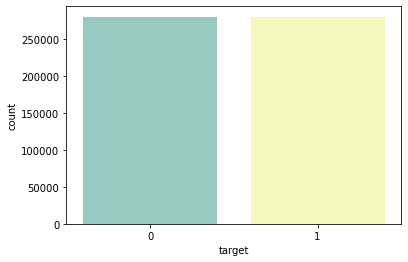

In [24]:
sns.countplot(data=train_label, x="target", palette="Set3", )

In [4]:
train_label['target'].value_counts()

0    280070
1    279930
Name: target, dtype: int64

In [5]:
train_label.isnull().sum() # pas de valeurs nulles

id        0
target    0
dtype: int64

In [5]:
train_label.head

<bound method NDFrame.head of                 id  target
0       00000e74ad       1
1       00001f4945       0
2       0000661522       0
3       00007a006a       0
4       0000a38978       1
...            ...     ...
559995  ffff9a5645       1
559996  ffffab0c27       0
559997  ffffcf161a       1
559998  ffffd2c403       0
559999  fffff2180b       0

[560000 rows x 2 columns]>

In [4]:
train_path = glob('/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/*/*/*/*')

In [4]:
len(train_path)

560000

In [5]:
explore_sample_3 = np.load(train_path[3])
explore_sample_3

array([[-8.97322811e-21, -9.08981214e-21, -9.10781750e-21, ...,
         3.19059676e-21,  3.00403337e-21,  2.97857101e-21],
       [-7.04594522e-21, -6.65557938e-21, -6.40358462e-21, ...,
        -9.99428929e-21, -9.43994447e-21, -9.06500416e-21],
       [ 2.08500902e-22,  4.89396387e-23,  2.69404290e-22, ...,
        -1.23806894e-21, -8.95287988e-22, -9.39066888e-22]])

In [5]:
explore_sample_2 = np.load(train_path[2])
explore_sample_2

array([[-6.51062379e-21, -6.88204098e-21, -6.97219625e-21, ...,
        -9.51094963e-21, -1.01669441e-20, -1.04220209e-20],
       [ 2.83841773e-21,  2.39752494e-21,  2.33458840e-21, ...,
        -3.10904473e-21, -3.07331333e-21, -2.43773611e-21],
       [-3.46568308e-21, -3.25792980e-21, -3.34102882e-21, ...,
        -1.40477453e-22, -2.92835178e-22, -6.35602957e-23]])

In [35]:
explore_sample_3.shape

(3, 4096)

In [38]:
explore_sample_2.shape

(3, 4096)

In [6]:
print(len(explore_sample_3[0]), len(explore_sample_3[1]), len(explore_sample_3[2]))

4096 4096 4096


In [7]:
train_path[3]

'/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999f7e72ad.npy'

In [8]:
rind = train_path[3].rindex('/') # last index where the character '/' appeared
extracted_id_for_explore_sample_3 = train_path[3][rind+1:].replace('.npy', '') # replaced .npy
extracted_id_for_explore_sample_3

'999f7e72ad'

In [9]:
train_label[train_label['id']==extracted_id_for_explore_sample_3]['target']

335552    1
Name: target, dtype: int64

In [10]:
positive_sample = explore_sample_3
# index 1 od train_path has a target of 0 so it is a negative sample.
negative_sample = np.load(train_path[1])
negative_sample

array([[ 1.66000845e-20,  1.63998702e-20,  1.65739614e-20, ...,
        -2.12423920e-21, -2.78651559e-21, -3.33370389e-21],
       [ 2.67268007e-21,  2.46722653e-21,  2.00417602e-21, ...,
         1.70840887e-21,  1.99257486e-21,  1.87521953e-21],
       [ 5.23211649e-22,  8.14234979e-22,  8.72233615e-22, ...,
         2.25210449e-21,  2.33630955e-21,  2.38980557e-21]])

In [9]:
samples = (positive_sample, negative_sample)
targets = (1, 0)

0it [00:00, ?it/s]

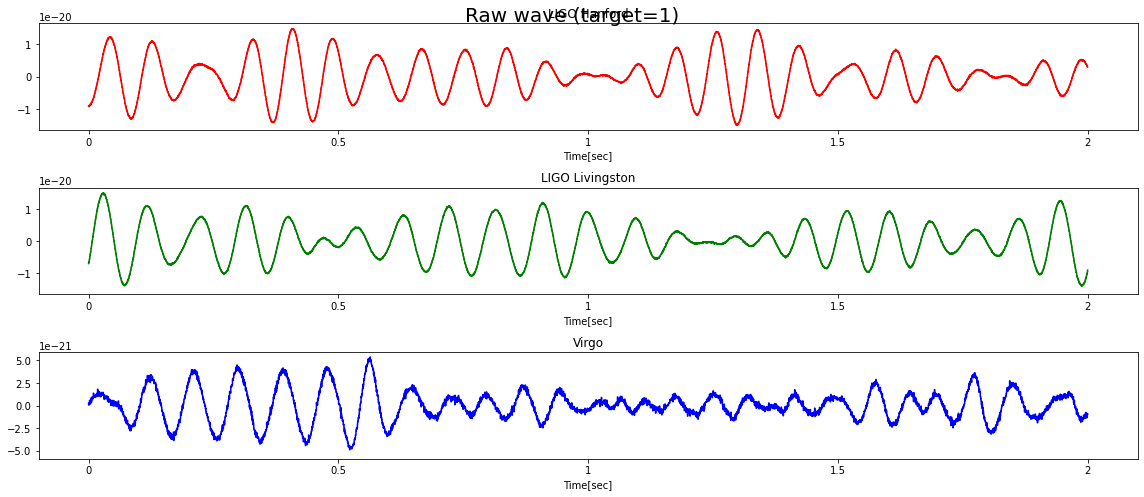

1it [00:00,  1.36it/s]

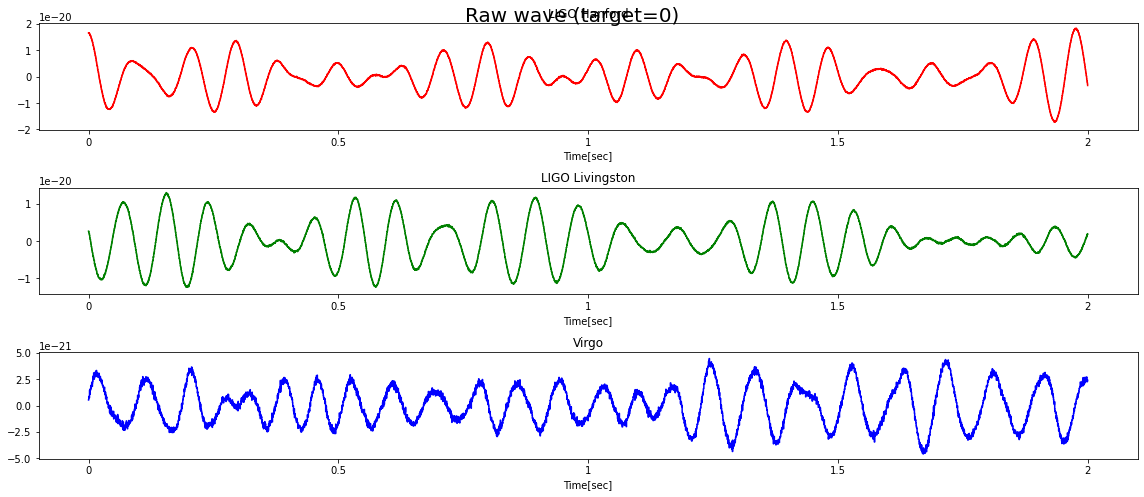

2it [00:01,  1.57it/s]


In [10]:
colors = ("red", "green", "blue")
signal_names = ("LIGO Hanford", "LIGO Livingston", "Virgo")

for x, i in tqdm(zip(samples, targets)):
    figure = plt.figure(figsize=(16, 7))
    figure.suptitle(f'Raw wave (target={i})', fontsize=20)
    # range is 3 because we have 3 different rows for each interferometers
    for j in range(3):
        axes = figure.add_subplot(3, 1, j+1)
        librosa.display.waveshow(x[j], sr=2048, ax=axes, color=colors[j])
        axes.set_title(signal_names[j], fontsize=12)
        axes.set_xlabel('Time[sec]')
    plt.tight_layout()
    plt.show()

In [30]:
sns.distplot(positive_sample[0,:])

NameError: name 'positive_sample' is not defined

In [6]:
pd.set_option('display.max_colwidth',None)

In [7]:
ids = []
for files in train_path:
    ids.append(files[files.rindex('/')+1:].replace('.npy',''))
df = pd.DataFrame({"id":ids,"path":train_path})
df = pd.merge(df, train_label, on='id')

In [8]:
df.head()

,id,path,target
0,999ad4156d,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999ad4156d.npy,0
1,999b57891b,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b57891b.npy,1
2,999b4f080f,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b4f080f.npy,0
3,999f7e72ad,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999f7e72ad.npy,1
4,999a097c74,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999a097c74.npy,1


In [9]:
df.to_csv('tableau_kaggle.csv')

In [10]:
train_label.shape

(560000, 2)

In [11]:
df.shape

(560000, 3)

In [78]:
df

,id,path,target
0,999ad4156d,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999ad4156d.npy,0
1,999b57891b,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b57891b.npy,1
2,999b4f080f,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b4f080f.npy,0
3,999f7e72ad,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999f7e72ad.npy,1
4,999a097c74,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999a097c74.npy,1
...,...,...,...
559995,555b06974b,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555b06974b.npy,1
559996,555e0035d9,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555e0035d9.npy,0
559997,555aef081e,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555aef081e.npy,0
559998,555c01f5eb,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555c01f5eb.npy,1


In [29]:
# let's define some signal parameters
sample_rate = 2048 # data is provided at 2048 Hz
signal_length = 2 # each signal lasts 2 s
fmin, fmax = 20, 500 # filter above 20 Hz, and max 1024 Hz (Nyquist freq = sample_rate/2)
hop_length = 64 # hop length parameter for the stft

# model compile params
batch_size = 250 # size in which data is processed and trained at-once in model
epochs = 3 # number of epochs (keep low as dataset is quite large 3~5 is enough as observed)

In [30]:
def get_npy_filepath(id_, is_train=True):
    path = ''
    if is_train:
        return f'/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'
    else:
        return f'/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/test/{id_[0]}/{id_[1]}/{id_[2]}/{id_}.npy'

In [31]:
# Define the Constant Q-Transform
cq_transform = CQT1992v2(sr=sample_rate, fmin=fmin, fmax=fmax, hop_length=hop_length)


CQT kernels created, time used = 0.0143 seconds


In [32]:
# function to load the file, preprocess, return the respective Constant Q-transform
def parse_function(id_path):
    # load the npy file
    signals = np.load(id_path.numpy())
    
    # loop through each signal
    for i in range(signals.shape[0]):
        # normalize the signal data
        signals[i] /= np.max(signals[i])
    
    # stack the arrays into a single vector
    signals = np.hstack(signals)
    
    # convert the signals to torch.tensor to pass to CQT
    signals = torch.from_numpy(signals).float()
    
    # get the CQT
    image = cq_transform(signals)
    
    # conver the image from torch.tensor to array
    image = np.array(image)
    
    # transpose the image to get right orientation
    image = np.transpose(image,(1,2,0))
    
    # conver the image to tf.tensor and return
    return tf.convert_to_tensor(image)

In [12]:
df

,id,path,target
0,999ad4156d,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999ad4156d.npy,0
1,999b57891b,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b57891b.npy,1
2,999b4f080f,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999b4f080f.npy,0
3,999f7e72ad,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999f7e72ad.npy,1
4,999a097c74,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/9/9/9/999a097c74.npy,1
...,...,...,...
559995,555b06974b,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555b06974b.npy,1
559996,555e0035d9,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555e0035d9.npy,0
559997,555aef081e,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555aef081e.npy,0
559998,555c01f5eb,/Users/valiconastrid/Desktop/EKAP S3/SVM et réseaux de neurones/Kaggle/train/5/5/5/555c01f5eb.npy,1


In [33]:
# plot a sample
image = parse_function(tf.convert_to_tensor(df['path'][1]))
print(image.shape)

(56, 193, 1)


TypeError: Invalid shape (56, 193, 1) for image data

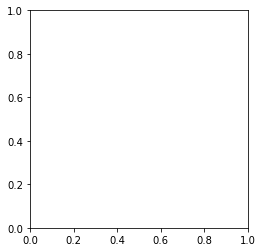

In [36]:
plt.imshow(image)

In [38]:
input_shape = (56, 193, 1)

In [43]:
X = df['id']
y = df['target'].astype('int8').values

In [44]:
# Split the training IDs into training & validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, stratify=y)

# Assign the test IDs
X_test = test[['id']]

In [46]:
# the tf_function which is called in the data pipeline. This runs as TF function
def tf_parse_function(id_path, y=None):
    # pass the id_path to the py_function parse_function
    [x] = tf.py_function(func=parse_function, inp=[id_path], Tout=[tf.float32])
    
#     x.set_shape(signal_shape) # signal_shape
    x = tf.ensure_shape(x, input_shape)
    
    # if train/valid then return x, y; for test only return x
    if y is None:
        return x
    else:
        return x, y

In [62]:
print(y_train)

[0 1 0 ... 1 0 0]


In [56]:
# train dataset
# Get the data filepaths as tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.apply(get_npy_filepath).values, y_train))

# shuffle the dataset
train_dataset = train_dataset.shuffle(len(X_train))

# apply the map method to tf_parse_function()
train_dataset = train_dataset.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# set batch size of the dataset
train_dataset = train_dataset.batch(batch_size)

# prefetch the data
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [63]:
# test dataset
# Get the data filepaths as tensor_slices
test_dataset = tf.data.Dataset.from_tensor_slices((X_valid.apply(get_npy_filepath).values, y_valid))

# apply the map method to tf_parse_function()
test_dataset = test_dataset.map(tf_parse_function, num_parallel_calls=tf.data.AUTOTUNE)

# set batch size of the dataset
test_dataset = test_dataset.batch(batch_size)

# prefetch the data
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [68]:
# Instantiate the Sequential model
model_cnn = Sequential(name='CNN_model')

# Add the first Convoluted2D layer w/ input_shape & MaxPooling2D layer followed by that
model_cnn.add(Conv2D(filters=16,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_01'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_01'))

# Second pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=32,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_02'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_02'))

# Third pair of Conv1D and MaxPooling1D layers
model_cnn.add(Conv2D(filters=64,
                     kernel_size=3,
                     input_shape=input_shape,
                     activation='relu',
                     name='Conv_03'))
model_cnn.add(MaxPooling2D(pool_size=2, name='Pool_03'))

# Add the Flatten layer
model_cnn.add(Flatten(name='Flatten'))

# Add the Dense layers
model_cnn.add(Dense(units=512,
                activation='relu',
                name='Dense_01'))
model_cnn.add(Dense(units=64,
                activation='relu',
                name='Dense_02'))

# Add the final Output layer
model_cnn.add(Dense(1, activation='sigmoid', name='Output'))

In [69]:
model_cnn.summary()

Model: "CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_01 (Conv2D)             (None, 54, 191, 16)       160       
_________________________________________________________________
Pool_01 (MaxPooling2D)       (None, 27, 95, 16)        0         
_________________________________________________________________
Conv_02 (Conv2D)             (None, 25, 93, 32)        4640      
_________________________________________________________________
Pool_02 (MaxPooling2D)       (None, 12, 46, 32)        0         
_________________________________________________________________
Conv_03 (Conv2D)             (None, 10, 44, 64)        18496     
_________________________________________________________________
Pool_03 (MaxPooling2D)       (None, 5, 22, 64)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 7040)              0 

In [72]:
model_cnn.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=[[AUC(), 'accuracy']])